# Coriolis Flights
*How to uncover insignificant truths that don't matter...*

In [1]:
# Section yet to be written...

## Introduction
Section yet to be written...

In [ ]:
# Section yet to be written...

## Mathematical Description of Calculations
---

### Distances and Directions
---
Given geographical coordinates of *origin* and *destination*, we can use the Haversine Formula to calculate the *distance* between locations, further more we can also convert geographical coordinates to cartesian ones, calculate a *(direction) vector* pointing from origin to destination and scale it to $|1|$ for a *representation of direction* of the flight. 

### Timespans and Timestamps
---
Given the timestamps of departure and arrival, we assume airtime is defined as the timedelta between the timestamps *wheels on* (landing) and *wheels off* (takeoff), what can be written as: $$ airtime = landing - takeoff .$$ 

### Combination of Timespans and Distances 
---
This timespan allows to be parameterized with the same number of steps as the *distance*, allowing to pinpoint the flights current location on the trajectory, and with that the *current Latitude* which can be converted to *radians*. 

### Average Velocity
---
Taken 1. and 2. into account we assume an *average velocity* per $$ velocity = \frac{distance}{airtime} .$$ Therewith we can represent a flights location with the prior calculated *(direction) vector* and multiplied by the flights *velocity*

$$
Velocity * DirectionVector = ScaledDirection.
$$

### Rotationmatrix for Coriolis Force 
---
Taken into account the earth is not a perfect Sphere, we assume $ PolarRadius = 6371.0 $ km and $ EquatorialRadius = 6378.137 $ km, therewith we contiune:  

$$
radius = PolarRadius * (1 - 0.5 * (1 - cos(latitude))) + \\
EquatorialRadius * (0.5 * (1 - cos(latitude))),
$$

to calculate the current *radius* of the Earth.


Given a *radius*, and an *angular velocity* (omega) we may represent rotation per: 

$$ 
Rotationmatrix = \begin{pmatrix}
0 & -omega*cos(radius) & omega*sin(radius)\\
omega*cos(radius) & 0 & 0\\
-omega*sin(radius) & 0 & 0
\end{pmatrix},
$$

where we set $ omega = 7.2921159e^{-5}  rad/s $ for representation of Earths velocity.

### Coriolis Acceleration, Velocity and Distance
---
Calculation of the Rotationmatrix at each timestep **t** for a flight allows integration over time:

$$
CoriolisAcceleration = Rotationmatrix * ScaledDirection,
$$


$$
CoriolisVelocity = \int_{0}^{t} CoriolisAcceleration\, dt,
$$

as well as: 

$$
CoriolisDriftDistance = \int_{0}^{t} CoriolisVelocity\, dt,
$$

wherein setting $ t = airtime $ delivers:

$$
TotalDriftDistance = \int_{0}^{airtime} \int_{0}^{airtime} CoriolisAcceleration\, dt \, dt, 
$$

which is a theoretical distance a flights *drifts* caused by the Coriolis Effect.

### Interim Results 
---

#### Sums of Distances
---
| Distance | Description |
| -: | --- |
| 3,507,476,408.99 km | Given Distance |
| 3,506,000,878.64 km | Haversine Distance |
| 928,589,014.17 km | Drift Distance |

#### Relation of Traveldistance to Driftdistance
---
| Ratio | Equation |
| -: | --- |
| 0.264746 | $ = \frac{DriftDistance}{GivenDistance} .$ |
| 0.264857 | $ = \frac{DriftDistance}{HaversineDistance} .$ |

#### Drift Percentage per travelled Distance
---
| Percentage | Relation |
| -: | --- |
| 26.47% | Drift percentage per given distance |
| 26.49% | Drift percentage per haversine distance |

# Coriolis Effect Calculations
---

## Versions of libraries

- `numpy` - 2.1.3
- `pandas` - 2.2.3
- `geopandas` - 1.0.1 
- `geodatasets` - 2024.8.0
- `scikit-learn` - 1.5.2

## Loading Libraries and Datasets

### Checking Python Version

In [2]:
import sys 
print(sys.version_info)

sys.version_info(major=3, minor=13, micro=0, releaselevel='final', serial=0)


### Loading build-in and third-party libraries

In [3]:
# Build in libs
import gc
import time 

# Dependencies
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas as pd
import geopandas as gpd

import geodatasets
from shapely.geometry import Point, box

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN

### Loading other dependencies

In [4]:
from coriolis_module import coriolis_module

In [5]:
from coriolis_functions import coriolis_functions

In [6]:
print(dir(coriolis_module))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_drift_distances', 'calculate_velocities', 'coriolis_acc', 'direction_vector', 'haversine', 'radius_at_latitude', 'rotation_matrix']


In [7]:
print(dir(coriolis_functions))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_total_drift', 'coriolis_acc', 'coriolis_integral', 'direction_vector', 'haversine', 'main', 'np', 'radius_at_latitude', 'rotation_matrix']


### Loading in core dataset

In [8]:
org_fdf = pd.read_csv("data/flights_sample_3m.csv").astype(
    {
        "FL_DATE": "datetime64[ns]", 
        "AIRLINE": "category", 
        "AIRLINE_DOT": "category", 
        "AIRLINE_CODE": "category", 
        "ORIGIN": "category", 
        "ORIGIN_CITY": "category", 
        "DEST": "category",
        "DEST_CITY": "category", 
        "CANCELLED": "bool",
        "CANCELLATION_CODE": "category", 
        "DIVERTED": "bool",
        
    }
)

In [9]:
print(org_fdf.dtypes)

FL_DATE                    datetime64[ns]
AIRLINE                          category
AIRLINE_DOT                      category
AIRLINE_CODE                     category
DOT_CODE                            int64
FL_NUMBER                           int64
ORIGIN                           category
ORIGIN_CITY                      category
DEST                             category
DEST_CITY                        category
CRS_DEP_TIME                        int64
DEP_TIME                          float64
DEP_DELAY                         float64
TAXI_OUT                          float64
WHEELS_OFF                        float64
WHEELS_ON                         float64
TAXI_IN                           float64
CRS_ARR_TIME                        int64
ARR_TIME                          float64
ARR_DELAY                         float64
CANCELLED                            bool
CANCELLATION_CODE                category
DIVERTED                             bool
CRS_ELAPSED_TIME                  

In [10]:
print(f"{len(org_fdf):,} : Rows in the core dataset.")

3,000,000 : Rows in the core dataset.


### Loading in additional dataset containing geographical coordinates

In [11]:
ldf = pd.read_csv("data/airports.csv").astype(
    {
        "IATA": "category",
        "AIRPORT": "category",
        "CITY": "category",
        "STATE": "category",
        "COUNTRY": "category",
    }
)

In [12]:
print(ldf.dtypes)

IATA         category
AIRPORT      category
CITY         category
STATE        category
COUNTRY      category
LATITUDE      float64
LONGITUDE     float64
dtype: object


In [13]:
print(f"{len(ldf):,} Rows in additional dataset")

341 Rows in additional dataset


### Setting index for later

In [14]:
org_fdf["primindex"] = org_fdf.index

## Data Preprocessing for Calculations

### Dropping Cancellations

In [15]:
fdf = org_fdf[~org_fdf["CANCELLED"]]

In [16]:
print(len(fdf))

2920860


### Dropping irrelevant columns

In [17]:
# droppting for calculations irrelevant columns
fdf = fdf.drop( ['AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',        
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'] ,axis=1)

### Dropping missing values

In [18]:
fdf = fdf.dropna()
print(len(fdf))

2920056


### Calculation and Visualisation of airtimes
Calculation of airtime defined as timedelta between wheels on and wheels off.

#### Functiondefinition

In [19]:
def convert_time(df, time_columns):
    """ Convert integer time columns to HH:MM format """
    for col in time_columns:
        # Handle missing values and convert times
        df[col] = df[col].fillna(0).astype(int).apply(lambda x: f"{x//100:02d}:{x%100:02d}")
        # Adjust for hours == 24
        df[col] = df[col].replace("24:00", "00:00")
    return df

#### Conversion 

In [20]:
# Applying the time conversion
fdf = convert_time(fdf, ["WHEELS_OFF", "WHEELS_ON"])

In [21]:
# Setting up datetime columns for wheels off and wheels on
fdf["woff_datetime"] = pd.to_datetime(fdf["FL_DATE"].astype(str) + " " + fdf["WHEELS_OFF"])
fdf["won_datetime"] = pd.to_datetime(fdf["FL_DATE"].astype(str) + " " + fdf["WHEELS_ON"])

In [22]:
# Drop original time columns
fdf.drop(["WHEELS_OFF", "WHEELS_ON"], axis=1)

,FL_DATE,ORIGIN,DEST,primindex,woff_datetime,won_datetime
0,2019-01-09,FLL,EWR,0,2019-01-09 12:10:00,2019-01-09 14:43:00
1,2022-11-19,MSP,SEA,1,2022-11-19 21:23:00,2022-11-19 22:32:00
2,2022-07-22,DEN,MSP,2,2022-07-22 10:20:00,2022-07-22 12:47:00
3,2023-03-06,MSP,SFO,3,2023-03-06 16:35:00,2023-03-06 18:44:00
4,2020-02-23,MCO,DFW,4,2020-02-23 18:53:00,2020-02-23 20:26:00
...,...,...,...,...,...,...
2999995,2022-11-13,JAX,CLT,2999995,2022-11-13 17:50:00,2022-11-13 18:45:00
2999996,2022-11-02,ORD,AUS,2999996,2022-11-02 13:04:00,2022-11-02 15:14:00
2999997,2022-09-11,HSV,ATL,2999997,2022-09-11 06:31:00,2022-09-11 07:59:00
2999998,2019-11-13,BOS,LGA,2999998,2019-11-13 16:14:00,2019-11-13 17:04:00


#### Calculation of airtime

In [23]:
# Calculating airtime based on time between wheels off and wheels on timestamps
fdf["airtime"] = fdf["won_datetime"] - fdf["woff_datetime"]

#### Removing implausible airtimes

In [24]:
# Dropping flights where airtime makes no sense
fdf = fdf[(fdf["airtime"].dt.total_seconds() > 0)]

In [25]:
print(len(fdf))

2777582


#### Visualisation of calculated airtime

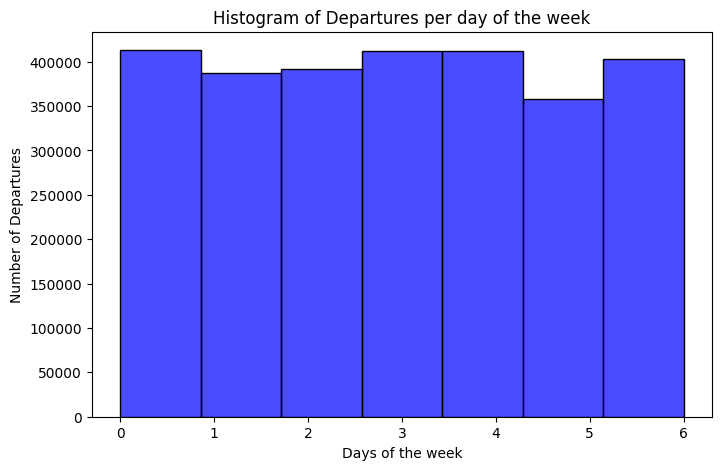

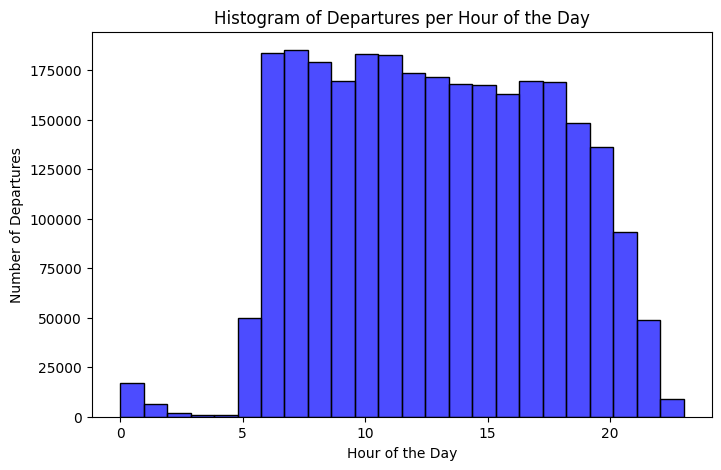

In [26]:
# Histogram of departures per day of the week
plt.figure(figsize=(8, 5))
sns.histplot(fdf["woff_datetime"].dt.dayofweek, bins=7, kde=False, color="blue", alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Departures per day of the week")
plt.xlabel("Days of the week")
plt.ylabel("Number of Departures")

# Showing the plot
plt.show()

# Histogram of departures per hour of the day
plt.figure(figsize=(8, 5))
sns.histplot(fdf["woff_datetime"].dt.hour, bins=24, kde=False, color='blue', alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Departures per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Departures")

# Showing the plot
plt.show()

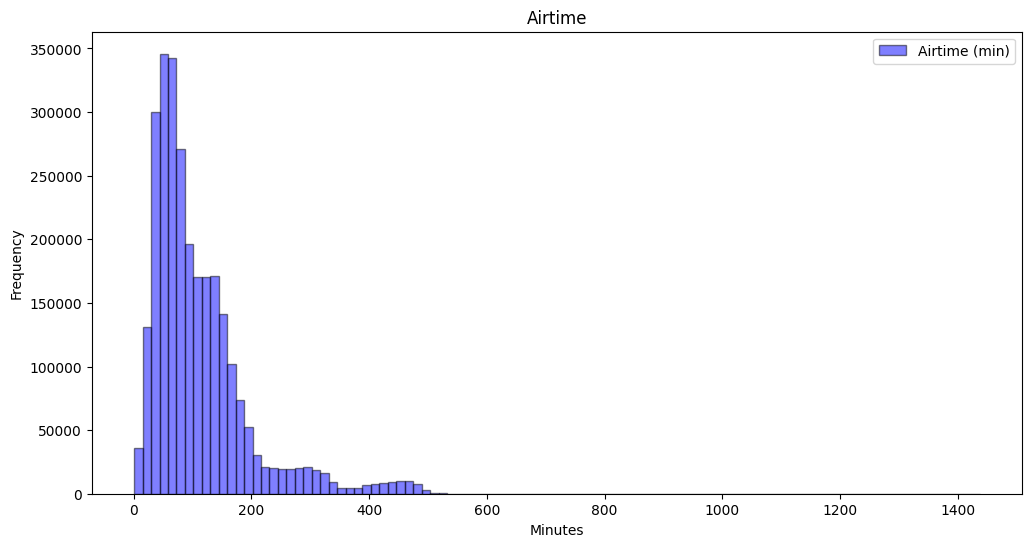

In [27]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(12, 6))

plt.hist(fdf["airtime"].dt.total_seconds()/60, bins=100, alpha=0.5, label="Airtime (min)", color="blue", edgecolor="black")

plt.title("Airtime")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

### Supplement Geographical Coordinates

#### Dataset merge to access geolocations
- Finding missing Airports
- Dropping rows with missing geographical locations
- Merge of both dataframes

In [28]:
# Checking unique values in both datasets
fdf_airports = set(fdf["ORIGIN"].unique()).union(set(fdf["DEST"].unique()))
ldf_airports = set(ldf["IATA"].unique())  

# Finding missing airport codes in ldf
missing_airports = fdf_airports.difference(ldf_airports)

# Dropping rows where "ORIGIN" or "DEST" are in missing_airports
fdf = fdf[~fdf["ORIGIN"].isin(missing_airports) & ~fdf["DEST"].isin(missing_airports)]

# Merging fdf with ldf to add geographical data for ORIGIN and DEST
fdf = pd.merge(fdf, ldf[["IATA", "LATITUDE", "LONGITUDE"]], 
                      left_on="ORIGIN", right_on="IATA", how="left")

fdf = pd.merge(fdf, ldf[["IATA", "LATITUDE", "LONGITUDE"]], 
                      left_on="DEST", right_on="IATA", how="left", suffixes=("_ORIGIN", "_DEST"))

# Dropping original origin and destination columns
fdf = fdf.drop(["ORIGIN", "DEST"], axis=1)

# Enforcing categories on newly generated columns
fdf[["IATA_ORIGIN", "IATA_DEST"]] = fdf[["IATA_ORIGIN", "IATA_DEST"]].astype("category")

### Aftermerge Print statements

In [29]:
print(f"{len(missing_airports)} : Number of Airport-Codes missing geographical coordinates.")
print(f"{len(fdf):,} Rows in the cleaned dataframe.")

53 : Number of Airport-Codes missing geographical coordinates.
2,730,145 Rows in the cleaned dataframe.


In [30]:
print(fdf.dtypes)

FL_DATE              datetime64[ns]
WHEELS_OFF                   object
WHEELS_ON                    object
primindex                     int64
woff_datetime        datetime64[ns]
won_datetime         datetime64[ns]
airtime             timedelta64[ns]
IATA_ORIGIN                category
LATITUDE_ORIGIN             float64
LONGITUDE_ORIGIN            float64
IATA_DEST                  category
LATITUDE_DEST               float64
LONGITUDE_DEST              float64
dtype: object


## Drift Calculations

### Setting a Timestamp

In [31]:
start_time = time.time()

### Calculation of Haversine Distance

In [32]:
fdf["haversine_distance"] = coriolis_functions.haversine(
    fdf["LATITUDE_ORIGIN"],
    fdf["LONGITUDE_ORIGIN"],
    fdf["LATITUDE_DEST"], 
    fdf["LONGITUDE_DEST"]
)

### Calculation of average velocity

In [33]:
fdf["average_velocity"] = fdf["haversine_distance"] / fdf["airtime"].dt.total_seconds()

### Calculation of straight direction...
...between origin and destination

In [34]:
# Applying direction vector function row-wise
directions = fdf.apply(
    lambda row: coriolis_module.direction_vector(
        row["LATITUDE_ORIGIN"], 
        row["LONGITUDE_ORIGIN"], 
        row["LATITUDE_DEST"], 
        row["LONGITUDE_DEST"]
    ), axis=1
)

In [35]:
# Split the resulting direction vectors into separate columns
fdf["x_direction"] = fdf["average_velocity"] * directions.apply(lambda x: x[0])
fdf["y_direction"] = fdf["average_velocity"] * directions.apply(lambda x: x[1])
fdf["z_direction"] = fdf["average_velocity"] * directions.apply(lambda x: x[2])

### Calculation of Drift Distances

In [36]:
def cpp_total_drift(row, airtime, num_steps=100):
    """
    Calculates the total drift distance due to Coriolis effect for a given row, 
    using code written in c++ and compiled into a python module.

    Args:
        row (pd.Series): A row from the DataFrame containing required data:
                         - 'haversine_distance': Distance in kilometers.
                         - 'x_direction', 'y_direction', 'z_direction': Direction components.
                         - 'LATITUDE_ORIGIN', 'LATITUDE_DEST': Latitude values.
        airtime (float): Total time over which the drift occurs (in seconds).
        num_steps (int): Number of steps for integration (default is 100).

    Returns:
        float: Total drift distance magnitude at the last time step (in kilometers).
    """

    coriolis_accelerations = coriolis_module.coriolis_acc(
        row["LATITUDE_ORIGIN"], row["LATITUDE_DEST"], 
        row["x_direction"], row["y_direction"], row["z_direction"],
        airtime, num_steps
    )

    coriolis_velocity = coriolis_module.calculate_velocities(coriolis_accelerations, airtime, num_steps)
    coriolis_drift_distance = coriolis_module.calculate_drift_distances(coriolis_velocity, airtime, num_steps)

    return np.linalg.norm(coriolis_drift_distance[-1])

In [37]:
# Applying function row by row
fdf["total_drift_distance"] = fdf.apply(
    lambda row: cpp_total_drift(
        row, row["airtime"].total_seconds(), num_steps=100  # adjust num_steps for precision
    ), axis=1
)

### Ending Timestamp

In [38]:
# Measureing time 
end_time = time.time()
print(f"{end_time - start_time:,.2f} : calculation time in seconds")

598.77 : calculation time in seconds


### Saving Results

In [39]:
# Merging the cleaned df with the original df using primindex
final_fdf = org_fdf.merge(fdf[["primindex", "total_drift_distance"]], on="primindex", how="left")

In [40]:
# Dropping selfset index before saving the file 
final_fdf = final_fdf.drop(["primindex"], axis=1)

In [41]:
# Saving file
final_fdf.to_csv("data/coriolis_flights.csv", index=False, sep=";", quoting=1)

# Exploratory Data Analysis
---

## Extracting more information from original dataset

In [42]:
# Merging the cleaned df with the original df using primindex
df = fdf.merge(org_fdf[[ 
    "primindex", 
    "ORIGIN_CITY",
    "DEST_CITY",
    "AIR_TIME",
    "ELAPSED_TIME", 
    "DEP_DELAY",
    "ARR_DELAY",
    "DISTANCE",
    
]], on="primindex", how="left")

In [43]:
df.dtypes

FL_DATE                  datetime64[ns]
WHEELS_OFF                       object
WHEELS_ON                        object
primindex                         int64
woff_datetime            datetime64[ns]
won_datetime             datetime64[ns]
airtime                 timedelta64[ns]
IATA_ORIGIN                    category
LATITUDE_ORIGIN                 float64
LONGITUDE_ORIGIN                float64
IATA_DEST                      category
LATITUDE_DEST                   float64
LONGITUDE_DEST                  float64
haversine_distance              float64
average_velocity                float64
x_direction                     float64
y_direction                     float64
z_direction                     float64
total_drift_distance            float64
ORIGIN_CITY                    category
DEST_CITY                      category
AIR_TIME                        float64
ELAPSED_TIME                    float64
DEP_DELAY                       float64
ARR_DELAY                       float64


## Popularity of Origins, Destinations and Routes

### Most popular Origins

In [44]:
# Scoping out Origin Cities with the highest count of flights
print(df["ORIGIN_CITY"].value_counts().head(20), "\n")

# Scoping out Origin Airports with the highest count of flights
print(df["IATA_ORIGIN"].value_counts().head(20))

ORIGIN_CITY
Chicago, IL              146036
Atlanta, GA              133727
Dallas/Fort Worth, TX    120257
Denver, CO               109118
New York, NY             105892
Charlotte, NC             86581
Houston, TX               82167
Los Angeles, CA           75462
Washington, DC            74672
Phoenix, AZ               65090
Las Vegas, NV             64196
Seattle, WA               63699
Orlando, FL               59432
Minneapolis, MN           57683
Detroit, MI               54863
Boston, MA                52671
San Francisco, CA         52588
Newark, NJ                48919
Salt Lake City, UT        47441
Philadelphia, PA          40844
Name: count, dtype: int64 

IATA_ORIGIN
ATL    133727
DFW    120257
ORD    114567
DEN    109118
CLT     86581
LAX     75462
PHX     65090
LAS     64196
SEA     63699
IAH     59598
MCO     59432
LGA     59056
MSP     57683
DTW     54863
BOS     52671
SFO     52588
DCA     50746
EWR     48919
SLC     47441
JFK     46836
Name: count, dtype: int64


### Most popular Destinations

In [45]:
# Scoping out Destination Cities with the highest count of flights
print(df["IATA_DEST"].value_counts().head(20), "\n")

# Scoping out Destination Airports with the highest count of flights
print(df["IATA_DEST"].value_counts().head(20))

IATA_DEST
ATL    145996
DFW    122629
DEN    111034
ORD    101410
CLT     90192
LAX     79246
PHX     68127
LAS     66771
SEA     66414
IAH     58903
DTW     58806
LGA     58651
MCO     58046
MSP     57037
SFO     55130
DCA     50943
SLC     50379
BOS     49633
EWR     46657
JFK     43833
Name: count, dtype: int64 

IATA_DEST
ATL    145996
DFW    122629
DEN    111034
ORD    101410
CLT     90192
LAX     79246
PHX     68127
LAS     66771
SEA     66414
IAH     58903
DTW     58806
LGA     58651
MCO     58046
MSP     57037
SFO     55130
DCA     50943
SLC     50379
BOS     49633
EWR     46657
JFK     43833
Name: count, dtype: int64


### Most popular Routes

#### ...between Cities

In [46]:
# Scoping out the top ten most popular routes (cities)
route_counts = df.groupby(["ORIGIN_CITY", "DEST_CITY"], observed=True).size().reset_index(name="flight_count")
most_pop_routes = route_counts.sort_values(by="flight_count", ascending=False)
most_pop_routes.head(10)

,ORIGIN_CITY,DEST_CITY,flight_count
4046,"New York, NY","Chicago, IL",6410
1187,"Chicago, IL","New York, NY",6130
693,"Boston, MA","New York, NY",5324
4036,"New York, NY","Boston, MA",5306
5403,"San Francisco, CA","Los Angeles, CA",5157
3335,"Los Angeles, CA","San Francisco, CA",4989
299,"Atlanta, GA","New York, NY",4657
4028,"New York, NY","Atlanta, GA",4622
2866,"Kahului, HI","Honolulu, HI",4587
3297,"Los Angeles, CA","Las Vegas, NV",4508


#### ...between Airports

In [47]:
# Scoping out the top ten most popular routes (IATA)
route_counts = df.groupby(["IATA_ORIGIN", "IATA_DEST"], observed=True).size().reset_index(name="flight_count")
most_pop_routes = route_counts.sort_values(by="flight_count", ascending=False)
most_pop_routes.head(10)

,IATA_ORIGIN,IATA_DEST,flight_count
6144,SFO,LAX,5157
3581,LAX,SFO,4989
4662,OGG,HNL,4587
3537,LAX,LAS,4508
2705,HNL,OGG,4490
3691,LGA,ORD,4488
3415,LAS,LAX,4431
4867,ORD,LGA,4349
3277,JFK,LAX,3897
712,BOS,DCA,3624


## Checking Dates

### Taking a look at flights per year

In [48]:
# Taking a look at total flights per year
df.groupby(df["FL_DATE"].dt.to_period("Y")).size()

FL_DATE
2019    694541
2020    426366
2021    562513
2022    623418
2023    423307
Freq: Y-DEC, dtype: int64

In [49]:
# Get flights in arbitrary intervalls of departure and arrival times
def get_woff(start, end):
    return df.loc[ (df["woff_datetime"] >= start) & (df["woff_datetime"] < end)]

def get_won(start, end):
    return  df.loc[ (df["won_datetime"] >= start) & (df["won_datetime"] < end)]

In [50]:
# Sorting departures by year
fl19 = get_woff("2019", "2020")
fl19 = fl19["woff_datetime"].dt.day_name().value_counts(normalize=True, sort=False)* 100

fl20 = get_woff("2020", "2021")
fl20 = fl20["woff_datetime"].dt.day_name().value_counts(normalize=True, sort=False)* 100

fl21 = get_woff("2021", "2022")
fl21 = fl21["woff_datetime"].dt.day_name().value_counts(normalize=True, sort=False)* 100

fl22 = get_woff("2022", "2023")
fl22 = fl22["woff_datetime"].dt.day_name().value_counts(normalize=True, sort=False)* 100

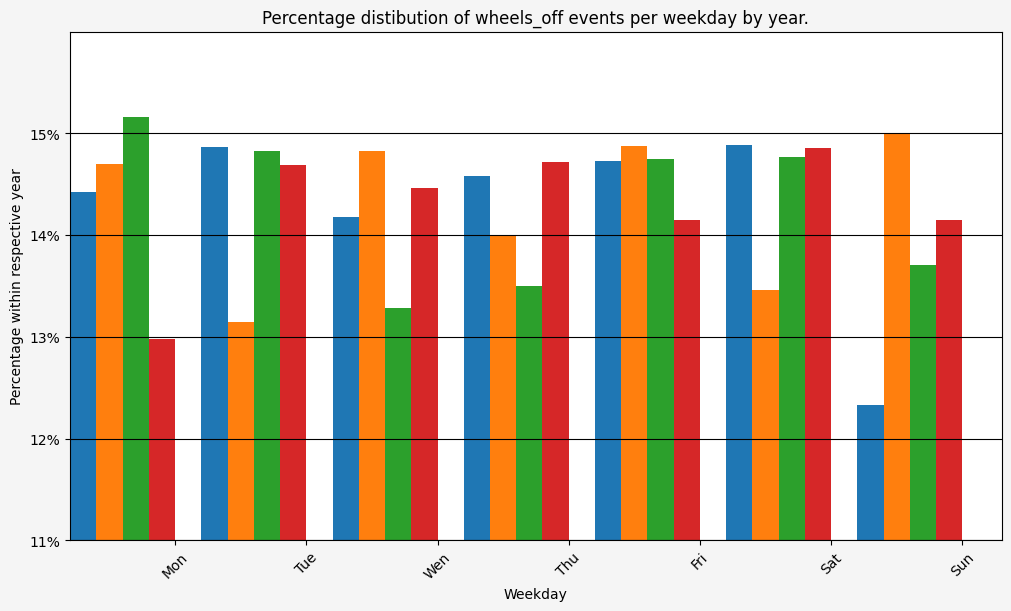

5

In [51]:
# Plotting bar plot 
fig, ax = plt.subplots(
    figsize=(10, 6),
    facecolor="whitesmoke",
    layout="constrained",
)

xtick_label=["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"]
ytick_label=[ str(x) + "%" for x in range(11, 16)]

ax.set_title("Percentage distibution of wheels_off events per weekday by year.")
ax.set_xlabel("Weekday")
ax.set_ylabel("Percentage within respective year")
ax.set_xticks([x + 0.7 for x in range(1, 8)], xtick_label, rotation=45)
ax.set_yticks([y for y in range(11, 16)], ytick_label)

ax.bar([x for x in range(1, 8)], fl19, width=0.2)
ax.bar([x + 0.2 for x in range(1, 8)], fl20, width=0.2)
ax.bar([x + 0.40 for x in range(1, 8)], fl21, width=0.2)
ax.bar([x + 0.6 for x in range(1, 8)], fl22, width=0.2)
ax.grid(True, color = "black", axis = "y")
ax.set(xlim=(0.9, 8), ylim=(11, 16))

# Show the plot
plt.show()

del fl19, fl20, fl21, fl22
gc.collect()

### Taking a look at flights per month

In [52]:
# Taking a look at total flights per month
df.groupby(df["FL_DATE"].dt.to_period("M")).size()

FL_DATE
2019-01    54556
2019-02    49930
2019-03    59562
2019-04    56509
2019-05    59179
2019-06    58558
2019-07    60693
2019-08    61631
2019-09    57398
2019-10    60438
2019-11    57247
2019-12    58840
2020-01    57737
2020-02    54561
2020-03    51616
2020-04    17778
2020-05    16602
2020-06    21922
2020-07    33946
2020-08    36132
2020-09    31155
2020-10    34173
2020-11    35232
2020-12    35512
2021-01    34821
2021-02    30162
2021-03    41911
2021-04    42957
2021-05    47156
2021-06    50425
2021-07    53992
2021-08    53448
2021-09    51208
2021-10    52724
2021-11    52075
2021-12    51634
2022-01    48299
2022-02    45173
2022-03    52873
2022-04    51365
2022-05    53855
2022-06    52827
2022-07    55033
2022-08    54288
2022-09    52792
2022-10    54621
2022-11    52053
2022-12    50239
2023-01    50887
2023-02    46978
2023-03    54134
2023-04    52230
2023-05    55138
2023-06    52950
2023-07    54842
2023-08    56148
Freq: M, dtype: int64

## Visualising Airtimes

### Conversion from timedelta to numerical minutes

In [53]:
# Conversion from timedelta to minutes
df["airtime"] = df["airtime"].dt.total_seconds()/60

### Boxplots

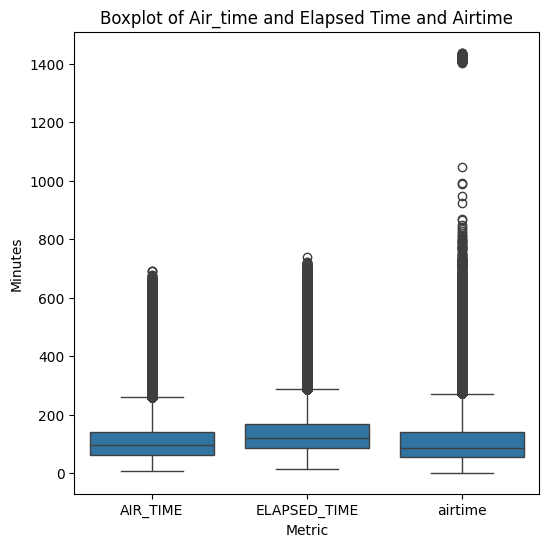

281

In [54]:
# Prepairing data for boxplots to take a view about outliers when it comes to flightdurations
melted_data = df.melt(value_vars=["AIR_TIME", "ELAPSED_TIME", "airtime"], 
                                         var_name="Metric", value_name="Minutes")

# Setting up the boxplots
plt.figure(figsize=(6,6))
sns.boxplot(x="Metric", y="Minutes", data=melted_data, legend=False)
plt.title("Boxplot of Air_time and Elapsed Time and Airtime")

# Showing plot 
plt.show()

del melted_data 
gc.collect()

### Histograms

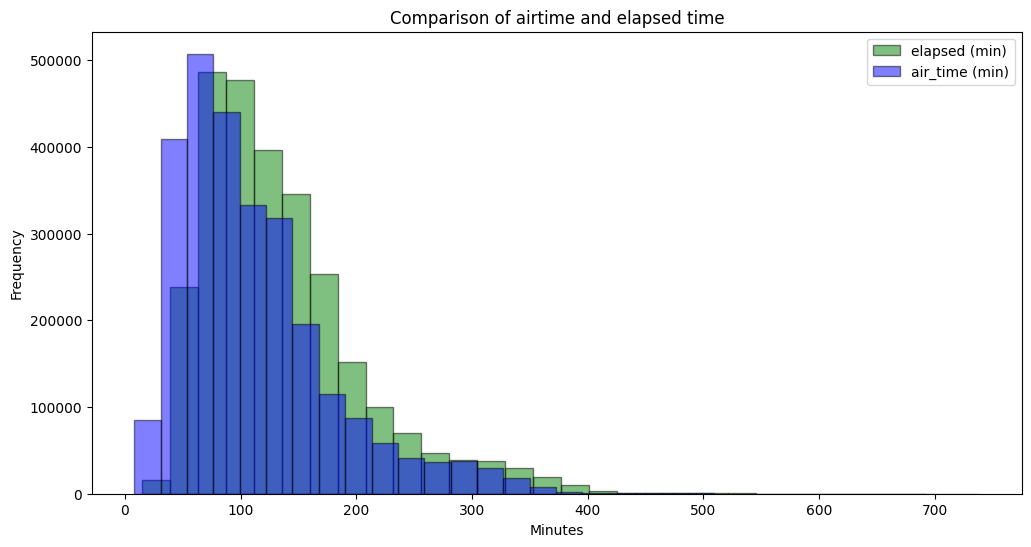

In [55]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(12, 6))

plt.hist(df["ELAPSED_TIME"], bins=30, alpha=0.5, label="elapsed (min)", color="green", edgecolor="black")
plt.hist(df["AIR_TIME"], bins=30, alpha=0.5, label="air_time (min)", color="blue", edgecolor="black")

plt.title("Comparison of airtime and elapsed time")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

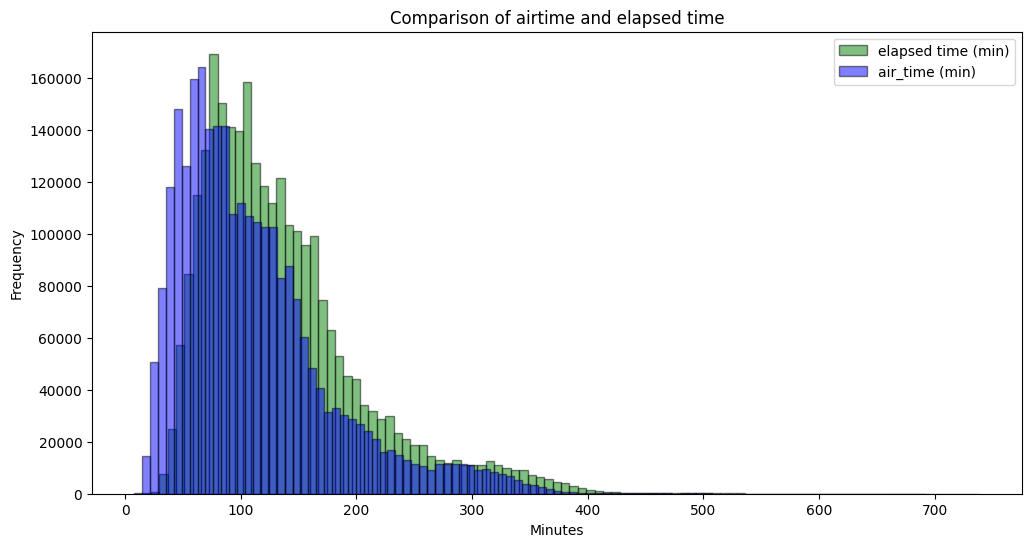

In [56]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(12, 6))

plt.hist(df["ELAPSED_TIME"], bins=100, alpha=0.5, label="elapsed time (min)", color="green", edgecolor="black")
plt.hist(df["AIR_TIME"], bins=100, alpha=0.5, label="air_time (min)", color="blue", edgecolor="black")

plt.title("Comparison of airtime and elapsed time")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

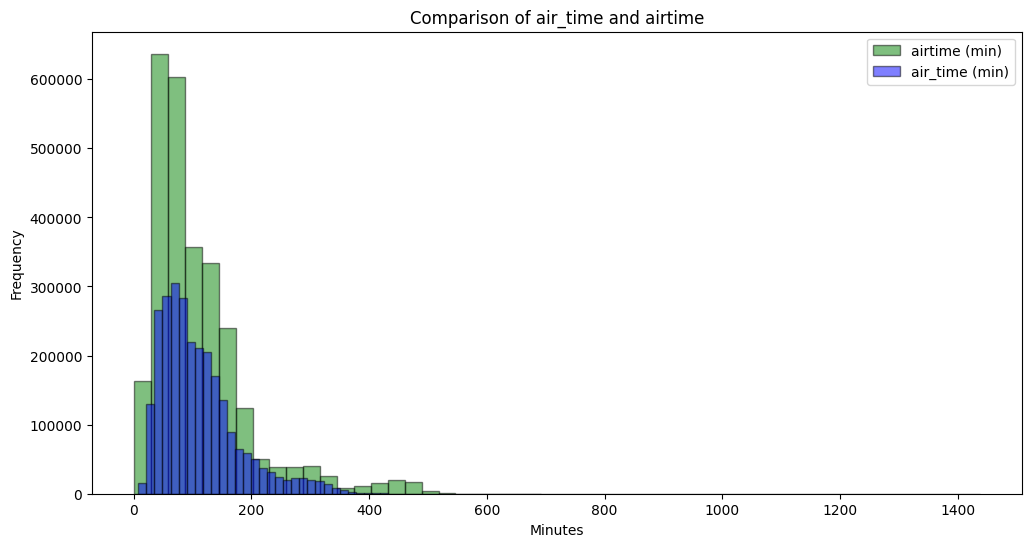

In [57]:
# Overlapping Histograms to compare air_time vs. airtime
plt.figure(figsize=(12, 6))

plt.hist(df["airtime"], bins=50, alpha=0.5, label="airtime (min)", color="green", edgecolor="black")
plt.hist(df["AIR_TIME"], bins=50, alpha=0.5, label="air_time (min)", color="blue", edgecolor="black")

plt.title("Comparison of air_time and airtime")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

### Scatterplot

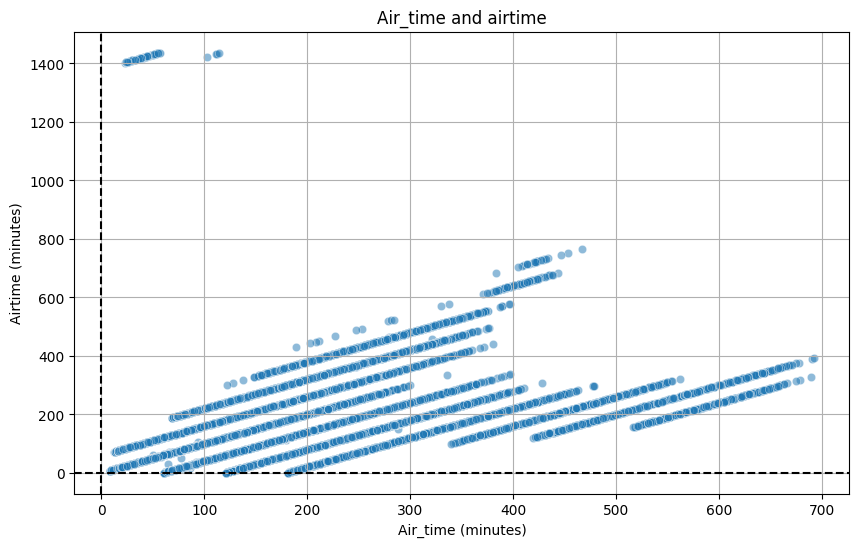

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="AIR_TIME", y="airtime", data=df, alpha=0.5)

plt.title("Air_time and airtime")
plt.xlabel("Air_time (minutes)")
plt.ylabel("Airtime (minutes)")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

plt.grid(True)
plt.show()

## Taking a look at Delays

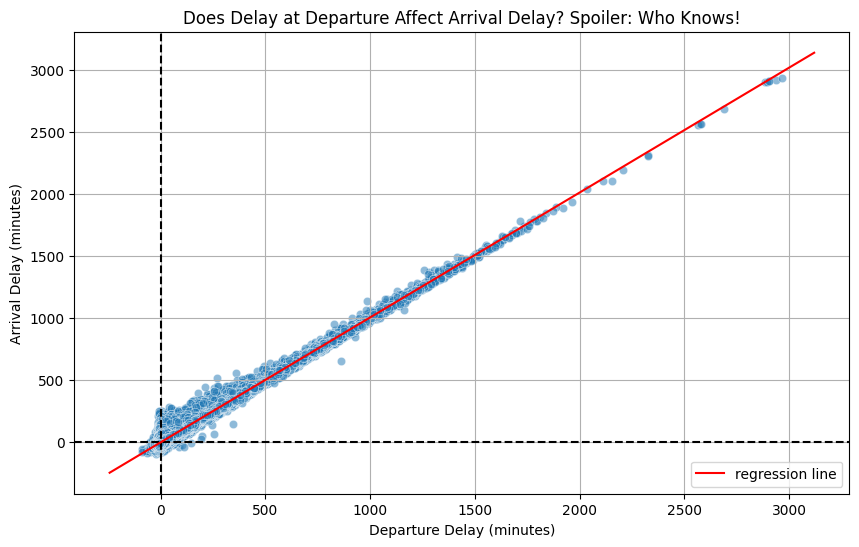

1.0077 : Slope.
-5.9012 : Intercept.
0.9262 : R²


26146

In [59]:
# Cleaning a temporary dataframe 
df_cleaned = df.dropna(subset=["DEP_DELAY", "ARR_DELAY"])

# Linear regression using scikit-learn and plotting it
X = df_cleaned["DEP_DELAY"].values.reshape(-1, 1)
Y = df_cleaned["ARR_DELAY"].values

model = LinearRegression()
model.fit(X, Y)

m = model.coef_[0]
b = model.intercept_
r_squared = model.score(X, Y)


# Checking if model checks out visually 
plt.figure(figsize=(10, 6))
sns.scatterplot(x="DEP_DELAY", y="ARR_DELAY", data=df_cleaned, alpha=0.5)

plt.title("Does Delay at Departure Affect Arrival Delay? Spoiler: Who Knows!")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# Adding in regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = b + m * x_vals
plt.plot(x_vals, y_vals, color="red", label="regression line")

plt.grid(True)
plt.legend(loc="lower right")
plt.show()

# Printing information about Regression
print(f"{m:,.4f} : Slope.")
print(f"{b:,.4f} : Intercept.")
print(f"{r_squared:.4f} : R²")

del df_cleaned, X, Y, x_vals, y_vals
gc.collect()

## Checking Geographical Locations

In [60]:
# Creating a GeoDataFrame from the merged data
geometry_origin = [Point(xy) for xy in zip(df["LONGITUDE_ORIGIN"], df["LATITUDE_ORIGIN"])]
geometry_dest = [Point(xy) for xy in zip(df["LONGITUDE_DEST"], df["LATITUDE_DEST"])]

# Creating separate GeoDataFrames for origin and destination airports
gdf_origin = gpd.GeoDataFrame(df, geometry=geometry_origin)
gdf_dest = gpd.GeoDataFrame(df, geometry=geometry_dest)

In [61]:
# Loading world data for the basemap
world_path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(world_path)

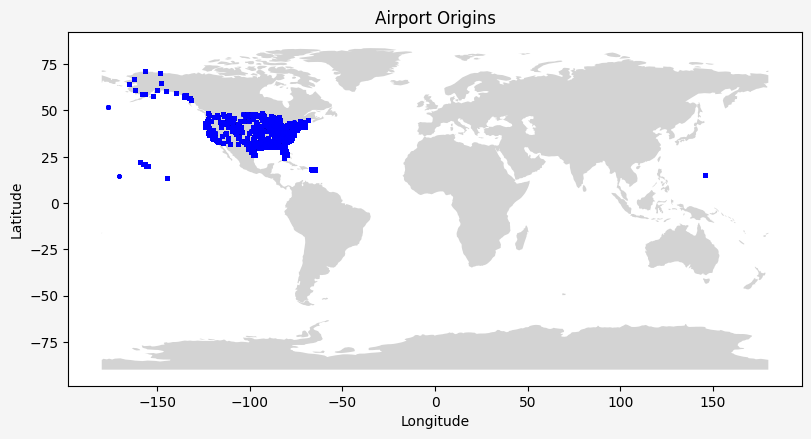

In [62]:
# Creating the figure and axes with Matplotlib
fig, ax = plt.subplots(figsize=(8, 4.5), facecolor="whitesmoke", layout="constrained")

# Plotting the world basemap on the axes
world.plot(ax=ax, color="lightgray")

# Plotting gdf_origin  (GeoDataFrame for airport origins)
gdf_origin.plot(ax=ax, marker="o", color="blue", markersize=5)

# Adding titles, labels, etc...
ax.set_title("Airport Origins")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

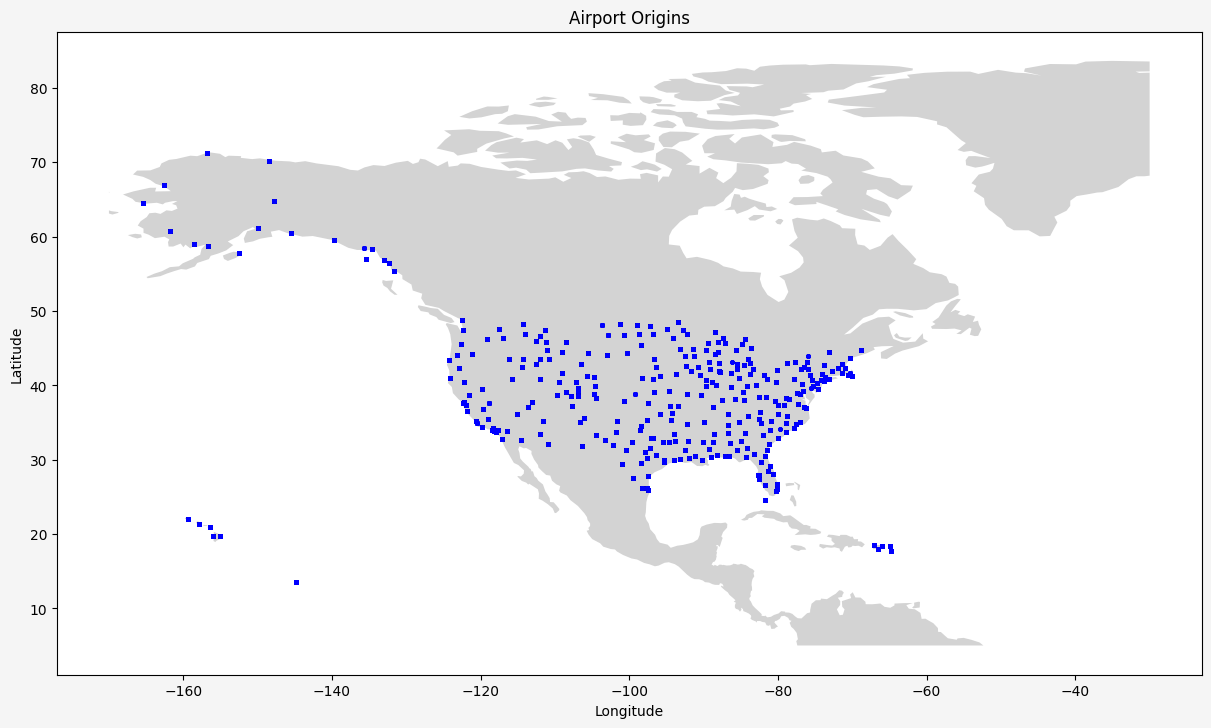

In [63]:
# Define bounding box for North America (roughly)
north_america_box = box(-170, 5, -30, 85)  # (min_lon, min_lat, max_lon, max_lat)

# Clipping the world land data to the bounding box of North America
north_america = world.clip(north_america_box)

# Define plot
fig, ax = plt.subplots(figsize=(12, 8), facecolor="whitesmoke", layout="constrained")

# Plotting northamerica
north_america.plot(ax=ax, color="lightgray")

# Plotting gdf_origin on top of it  (GeoDataFrame for airport origins)
gdf_origin[
    (85 >= gdf_origin["LATITUDE_ORIGIN"]) & 
    (gdf_origin["LATITUDE_ORIGIN"] >= 5) & 
    (-30 >= gdf_origin["LONGITUDE_ORIGIN"]) &
    (gdf_origin["LONGITUDE_ORIGIN"] >= -170)
].plot(ax=ax, marker="o", color="blue", markersize=5)

ax.set_title("Airport Origins")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

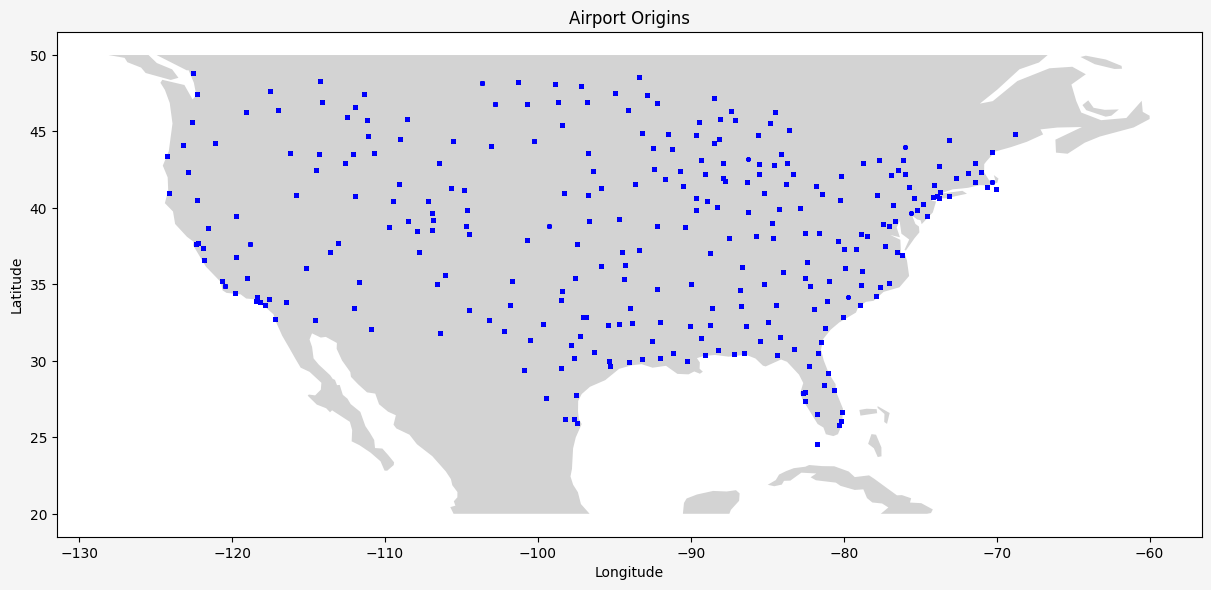

In [64]:
# USA (roughly)
north_america_box = box(-130, 20, -60, 50)  # (min_lon, min_lat, max_lon, max_lat)

# Clipping the world land data to the bounding box of North America
north_america = world.clip(north_america_box)

# Define plot
fig, ax = plt.subplots(figsize=(12, 8), facecolor="whitesmoke", layout="constrained")

# Plotting northamerica
north_america.plot(ax=ax, color="lightgray")

# Plotting gdf_origin on top of it  (GeoDataFrame for airport origins)
gdf_origin[
    (50 >= gdf_origin["LATITUDE_ORIGIN"]) & 
    (gdf_origin["LATITUDE_ORIGIN"] >= 20) & 
    (-60 >= gdf_origin["LONGITUDE_ORIGIN"]) &
    (gdf_origin["LONGITUDE_ORIGIN"] >= -130)
].plot(ax=ax, marker="o", color="blue", markersize=5)

ax.set_title("Airport Origins")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [65]:
# Cleaning memory
del world, north_america
del gdf_origin
del gdf_dest
del geometry_origin
del geometry_dest

gc.collect()

10874

# Drift Analysis
---

## Comparing Distance and Haversine Distance

In [66]:
# Conversion from Miles to Kilometers
df["DISTANCE"] = df["DISTANCE"] * 1.609344

### Histogram Overlay 

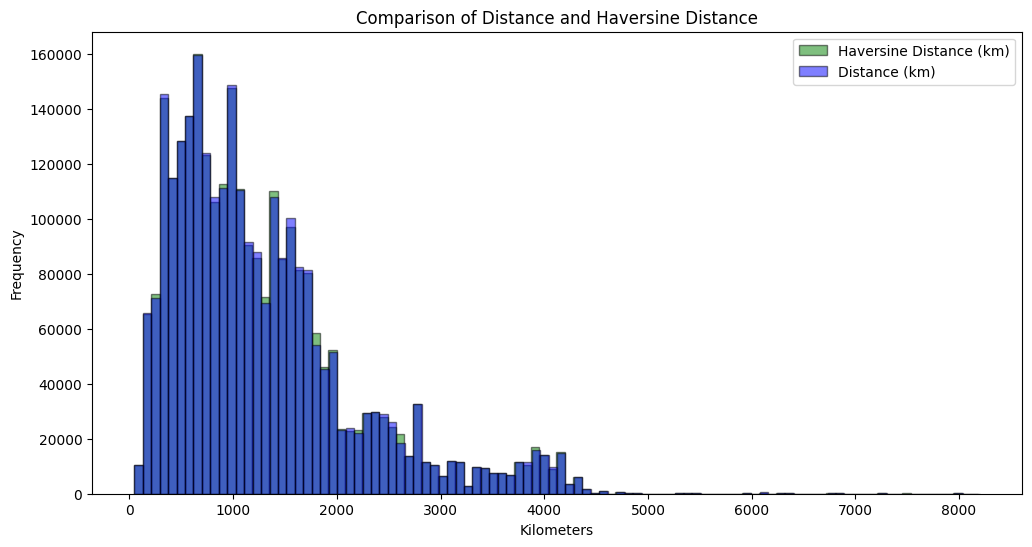

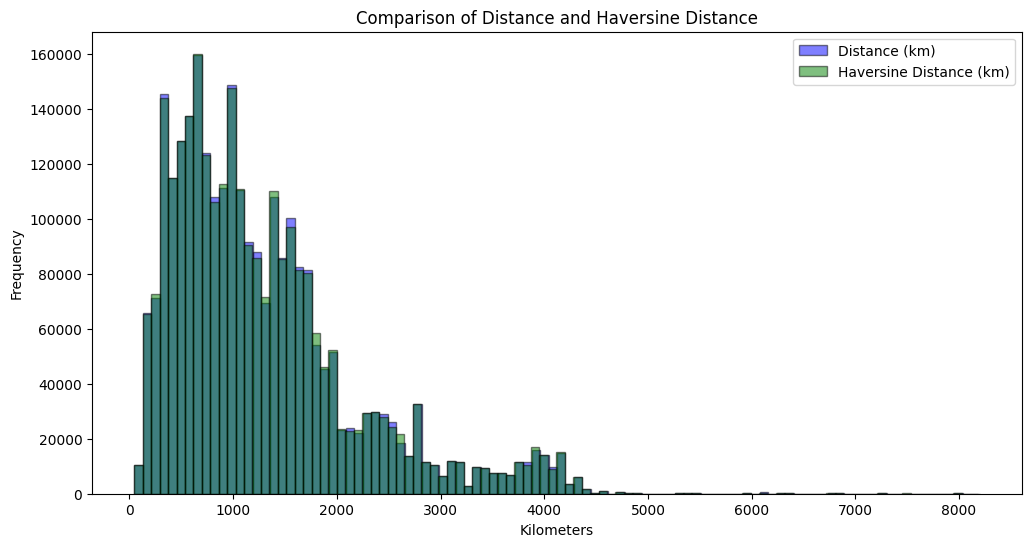

In [67]:
# Overlapping Histograms of Distance and Haversine Distance
plt.figure(figsize=(12, 6))

plt.hist(df["haversine_distance"], bins=100, alpha=0.5, label="Haversine Distance (km)", color="green", edgecolor="black")
plt.hist(df["DISTANCE"], bins=100, alpha=0.5, label="Distance (km)", color="blue", edgecolor="black")

plt.title("Comparison of Distance and Haversine Distance")
plt.xlabel("Kilometers")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

# Overlapping Histograms of Distance and Haversine Distance in different order
plt.figure(figsize=(12, 6))

plt.hist(df["DISTANCE"], bins=100, alpha=0.5, label="Distance (km)", color="blue", edgecolor="black")
plt.hist(df["haversine_distance"], bins=100, alpha=0.5, label="Haversine Distance (km)", color="green", edgecolor="black")

plt.title("Comparison of Distance and Haversine Distance")
plt.xlabel("Kilometers")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

### Printing total distances

In [68]:
# Printing sum, ratio and percentage of drift and travel distance
dist = df["DISTANCE"].sum()
hs_dist = df["haversine_distance"].sum()
td_dist = df["total_drift_distance"].sum()

dist_ratio = td_dist/dist
tdhs_ratio = td_dist/hs_dist

print(f"{dist:,.2f} km: Total travel distance given.")
print(f"{hs_dist:,.2f} km: Total haversine distance travelled.")
print(f"{td_dist:,.2f} km: Total drift distance of those travels.")
print()
print(f"{dist_ratio:,.06f} : Ratio of drift distance through distance.")
print(f"{100 *dist_ratio:.02f}% : Drift percentage in relation to distance on average.")
print()
print(f"{tdhs_ratio:,.06f} : Ratio of drift distance through haversine distance.")
print(f"{100 *tdhs_ratio:.02f}% : Drift percentage in relation to haversine distance on average.")

3,507,476,408.99 km: Total travel distance given.
3,506,000,878.64 km: Total haversine distance travelled.
928,589,014.17 km: Total drift distance of those travels.

0.264746 : Ratio of drift distance through distance.
26.47% : Drift percentage in relation to distance on average.

0.264857 : Ratio of drift distance through haversine distance.
26.49% : Drift percentage in relation to haversine distance on average.


## Regressions on "raw" results

### Elimination of Units 

In [69]:
# Division of drift through distance gives percentage
df.loc[:, "drift_factor"] = df["total_drift_distance"] / df["haversine_distance"].replace(0, pd.NA)

### Haversine Distance in relation to Drift Distance

In [70]:
# Linear regression using scikit-learn
X = df["haversine_distance"].values.reshape(-1, 1)
Y = df["total_drift_distance"].values

model = LinearRegression()
model.fit(X, Y)

sk_m = model.coef_[0]
sk_b = model.intercept_
r_squared = model.score(X, Y)

print(f"{sk_m:.6f} : Slope of linear Regression")
print(f"{sk_b:.6f} : Intercept of linear Regression")
print(f"{r_squared:.2f} : R² of linear Regression")

# Plotting regression
# plt.plot(x_vals, y_vals, color="red", label="regression line")

0.543660 : Slope of linear Regression
-358.033700 : Intercept of linear Regression
0.59 : R² of linear Regression


In [71]:
# Let's try a scond order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["total_drift_distance"], 2)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["total_drift_distance"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["total_drift_distance"] - np.mean(df["total_drift_distance"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polya_x_values = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polya_y_values = np.polyval(coefs, polya_x_values)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the second order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the second order polynomial.")

# Plotting polynomial
# plt.plot(poly_x_vals, poly_y_vals, color="red", label="polynomial fit")

0.000107 : Coefficent 0 of the second order polynomial.
0.125355 : Coefficent 1 of the second order polynomial.
-87.248007 : Coefficent 2 of the second order polynomial.
0.64: R² of the second order polynomial.


In [72]:
# Let's try a fifth order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["total_drift_distance"], 5)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["total_drift_distance"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["total_drift_distance"] - np.mean(df["total_drift_distance"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polyb_x_values = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polyb_y_values = np.polyval(coefs, polyb_x_values)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the fifth order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the fifth order polynomial.")

0.000000 : Coefficent 0 of the fifth order polynomial.
-0.000000 : Coefficent 1 of the fifth order polynomial.
0.000000 : Coefficent 2 of the fifth order polynomial.
-0.000553 : Coefficent 3 of the fifth order polynomial.
0.467353 : Coefficent 4 of the fifth order polynomial.
-84.345450 : Coefficent 5 of the fifth order polynomial.
0.67: R² of the fifth order polynomial.


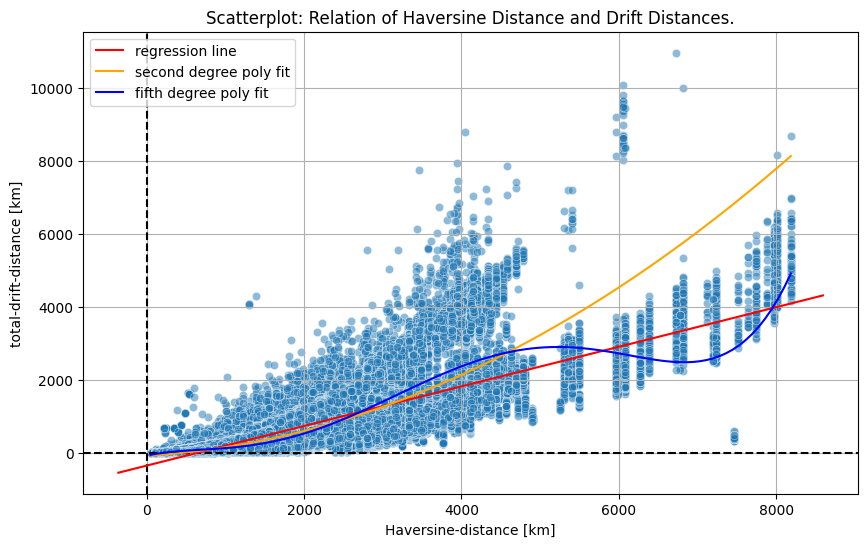

In [73]:
# Let's compare Visually
plt.figure(figsize=(10, 6))
sns.scatterplot(x="haversine_distance", y="total_drift_distance", data=df, alpha=0.5)

plt.title("Scatterplot: Relation of Haversine Distance and Drift Distances.")
plt.xlabel("Haversine-distance [km]")
plt.ylabel("total-drift-distance [km]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# Prepare to plot linear regression  
x_values = np.array(plt.gca().get_xlim())
y_values = sk_b + sk_m * x_values

# Plotting linear regression
plt.plot(x_values, y_values, color="red", label="regression line")

# Adding polynomials for plot
plt.plot(polya_x_values, polya_y_values, color="orange", label="second degree poly fit")
plt.plot(polyb_x_values, polyb_y_values, color="blue", label="fifth degree poly fit")

plt.grid(True)
plt.legend(loc="upper left")
plt.show()

### Haversine Distance in relation to Drift Factor

In [74]:
# Linear regression using scikit-learn
X = df["haversine_distance"].values.reshape(-1, 1)
Y = df["drift_factor"].values

model = LinearRegression()
model.fit(X, Y)

sk_m = model.coef_[0]
sk_b = model.intercept_
r_squared = model.score(X, Y)

print(f"{sk_m:.6f} : Slope of linear Regression")
print(f"{sk_b:.6f} : Intercept of linear Regression")
print(f"{r_squared:.2f} : R² of linear Regression")

# Plotting regression
# plt.plot(x_vals, y_vals, color="red", label="regression line")

0.000139 : Slope of linear Regression
-0.003113 : Intercept of linear Regression
0.45 : R² of linear Regression


In [75]:
# Let's try a scond order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["drift_factor"], 2)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["drift_factor"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["drift_factor"] - np.mean(df["drift_factor"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polya_x_vals = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polya_y_vals = np.polyval(coefs, polya_x_vals)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the second order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the second order polynomial.")

# Plotting polynomial
# plt.plot(poly_x_vals, poly_y_vals, color="red", label="polynomial fit")

0.000000 : Coefficent 0 of the second order polynomial.
0.000127 : Coefficent 1 of the second order polynomial.
0.004558 : Coefficent 2 of the second order polynomial.
0.45: R² of the second order polynomial.


In [76]:
# Let's try a fifth order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["drift_factor"], 5)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["drift_factor"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["drift_factor"] - np.mean(df["drift_factor"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# setup polynomial for plot
polyb_x_vals = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100)
polyb_y_vals = np.polyval(coefs, polyb_x_vals)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the fifth order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the fifth order polynomial.")

0.000000 : Coefficent 0 of the fifth order polynomial.
-0.000000 : Coefficent 1 of the fifth order polynomial.
0.000000 : Coefficent 2 of the fifth order polynomial.
-0.000000 : Coefficent 3 of the fifth order polynomial.
0.000142 : Coefficent 4 of the fifth order polynomial.
0.025291 : Coefficent 5 of the fifth order polynomial.
0.47: R² of the fifth order polynomial.


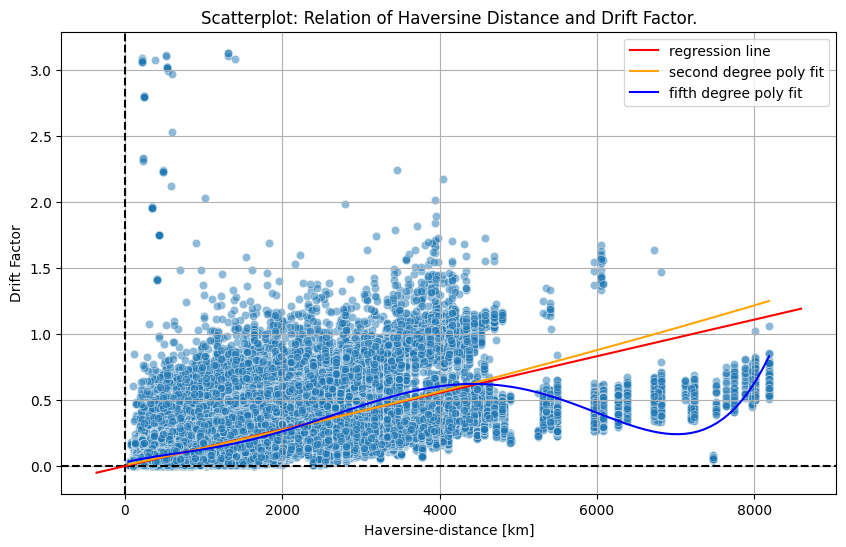

In [77]:
# Comparing regressions visually
plt.figure(figsize=(10, 6))
sns.scatterplot(x="haversine_distance", y="drift_factor", data=df, alpha=0.5)

plt.title("Scatterplot: Relation of Haversine Distance and Drift Factor.")
plt.xlabel("Haversine-distance [km]")
plt.ylabel("Drift Factor")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# Preparing linear regression for plot 
x_vals = np.array(plt.gca().get_xlim())
y_vals = sk_b + sk_m * x_vals

# Plotting linear regression
plt.plot(x_vals, y_vals, color="red", label="regression line")

# Adding polynomials for plot
plt.plot(polya_x_vals, polya_y_vals, color="orange", label="second degree poly fit")
plt.plot(polyb_x_vals, polyb_y_vals, color="blue", label="fifth degree poly fit")

plt.grid(True)
plt.legend(loc="upper right")
plt.show()

## Reducing Noise and KMeans Clustering

### Density-based spatial clustering of applications with noise (DBSCAN)

In [78]:
# Defining a function for DBSCAN and plotting
def db_scanner(data, df, epsilon, minimum_samples, x, y):
    # data = df[[f"{y}", f"{y}"]].to_numpy()

    # Configuring DBSCAN parameters
    dbscan = DBSCAN(eps=epsilon, min_samples=minimum_samples)
    clusters = dbscan.fit_predict(data)
    
    # Adding cluster labels to the dataframe
    df.loc[:, "cluster"] = clusters
    
    # Creating a figure with 2 subplots, one above the other
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    
    # First plot: including noise
    sns.scatterplot(x=x, y=y, data=df, hue="cluster", palette="viridis", alpha=0.5, ax=axes[0])
    axes[0].set_title("DBSCAN Clustering (Including Noise)")
    axes[0].set_xlabel(f"{x}")
    axes[0].set_ylabel(f"{y}")
    axes[0].legend(loc="upper left", title="Cluster")
    
    # Second plot: excluding noise
    sns.scatterplot(x=x, y=y, data=df[df["cluster"] != -1], hue="cluster", palette="viridis", alpha=0.5, ax=axes[1])
    axes[1].set_title("DBSCAN Clustering (Excluding Noise)")
    axes[1].set_xlabel(f"{x}")
    axes[1].set_ylabel(f"{y}")
    axes[1].legend(loc="upper left", title="Cluster")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print information about noise
    print(f"Not considered 'noise': {len(df[df['cluster'] != -1])}")
    print(f"Considered 'noise': {len(df[df['cluster'] == -1])}")

    # Cleaning up memory
    del clusters
    gc.collect()

    return df

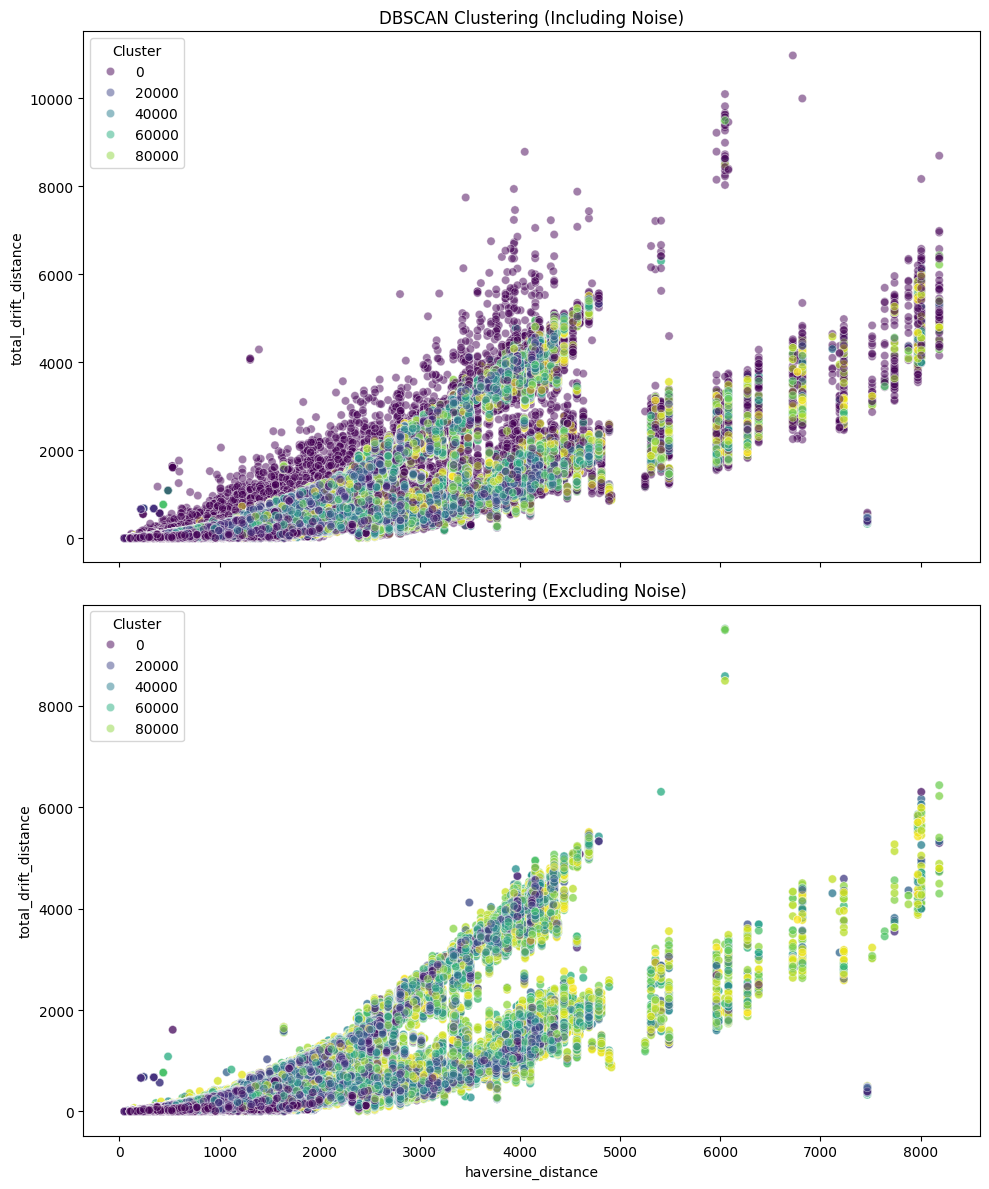

Not considered 'noise': 2689283
Considered 'noise': 40862


7766

In [79]:
# Extracting data into 2D numpy array
data = df[["haversine_distance", "total_drift_distance"]].to_numpy()

# Calling db_scanner for DBSCAN
df = db_scanner(data, df, 0.99, 2, "haversine_distance", "total_drift_distance")

# Cleaning up memory
del data
gc.collect()

### Dropping Noise

In [80]:
# Dropping noise 

# Printing number of rows before further cleaning
print(rows_before_cleaning := len(df), " : Rows currently in dataframe.")

# Drop outliers (rows labeled as -1) inplace
df.drop(df[df["cluster"] == -1].index, inplace=True)

# Printing number of rows after cleaning
print(len(df), " : Rows in dataframe after dropping 'noise'.")
print(rows_before_cleaning - len(df), " : Rows lost by cleaning.")

2730145  : Rows currently in dataframe.
2689283  : Rows in dataframe after dropping 'noise'.
40862  : Rows lost by cleaning.


### KMeans Clustering of Haversine Distance and Total Drift Distance

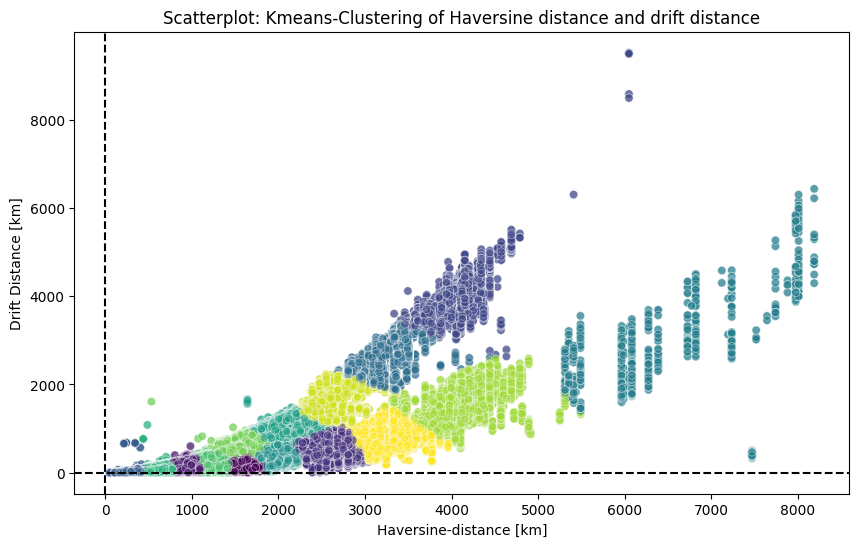

In [81]:
# Preprocessing for kmeans
kmeans_X = df[["haversine_distance", "total_drift_distance"]].values

# Applying kmeans
kmeans = KMeans(n_clusters=15, n_init=20, random_state=11)  # Adjusting number of clusters
kmeans.fit(kmeans_X)
df["kmeans_cluster"] = kmeans.labels_

# Plotting kmeans
plt.figure(figsize=(10, 6))
sns.scatterplot(x="haversine_distance", y="total_drift_distance", c=df["kmeans_cluster"], cmap="viridis", data=df, alpha=0.5)

plt.title("Scatterplot: Kmeans-Clustering of Haversine distance and drift distance")
plt.xlabel("Haversine-distance [km]")
plt.ylabel("Drift Distance [km]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

plt.show()

## Regressions without Noise

### Haversine Distance in relation to Drift Factor (clustered, with less noise)

In [82]:
# Linear regression using scikit-learn
X = df["haversine_distance"].values.reshape(-1, 1)
Y = df["drift_factor"].values

model = LinearRegression()
model.fit(X, Y)

sk_m = model.coef_[0]
sk_b = model.intercept_
r_squared = model.score(X, Y)

print(f"{sk_m:.6f} : Slope of linear Regression")
print(f"{sk_b:.6f} : Intercept of linear Regression")
print(f"{r_squared:.2f} : R² of linear Regression")

# Plotting regression
# plt.plot(x_vals, y_vals, color="red", label="regression line")

0.000139 : Slope of linear Regression
-0.003905 : Intercept of linear Regression
0.45 : R² of linear Regression


In [83]:
# Let's try a scond order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["drift_factor"], 2)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["drift_factor"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["drift_factor"] - np.mean(df["drift_factor"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polya_x_vals = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polya_y_vals = np.polyval(coefs, polya_x_vals)
                
# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the second order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the second order polynomial.")

# Plotting polynomial
# plt.plot(poly_x_vals, poly_y_vals, color="red", label="polynomial fit")

0.000000 : Coefficent 0 of the second order polynomial.
0.000118 : Coefficent 1 of the second order polynomial.
0.009063 : Coefficent 2 of the second order polynomial.
0.45: R² of the second order polynomial.


In [84]:
# Let's try a fifth order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["drift_factor"], 5)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["drift_factor"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["drift_factor"] - np.mean(df["drift_factor"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# setup polynomial for plot
polyb_x_vals = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100)
polyb_y_vals = np.polyval(coefs, polyb_x_vals)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the fifth order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the fifth order polynomial.")

0.000000 : Coefficent 0 of the fifth order polynomial.
-0.000000 : Coefficent 1 of the fifth order polynomial.
0.000000 : Coefficent 2 of the fifth order polynomial.
-0.000000 : Coefficent 3 of the fifth order polynomial.
0.000153 : Coefficent 4 of the fifth order polynomial.
0.022612 : Coefficent 5 of the fifth order polynomial.
0.47: R² of the fifth order polynomial.


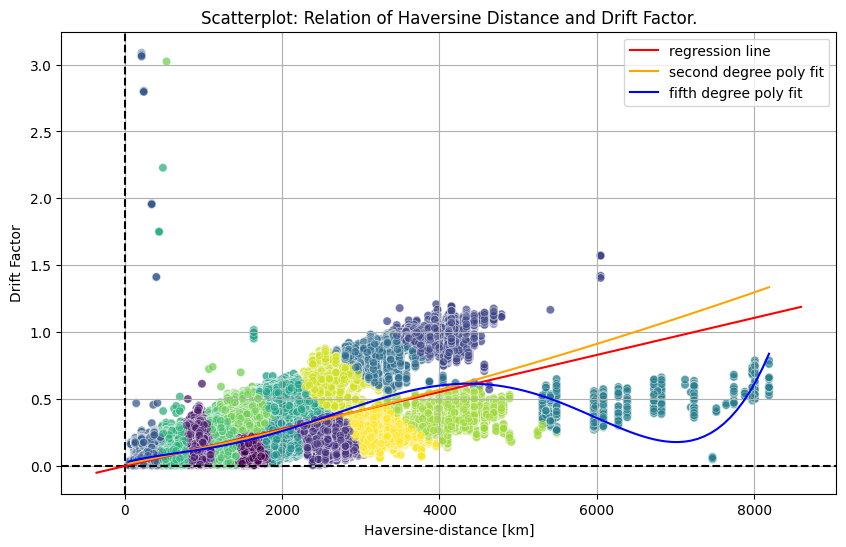

In [85]:
# Comparing regressions visually
plt.figure(figsize=(10, 6))
sns.scatterplot(x="haversine_distance", y="drift_factor", c=df["kmeans_cluster"], cmap="viridis", data=df, alpha=0.5)

plt.title("Scatterplot: Relation of Haversine Distance and Drift Factor.")
plt.xlabel("Haversine-distance [km]")
plt.ylabel("Drift Factor")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# Preparing for plot
x_vals = np.array(plt.gca().get_xlim())
y_vals = sk_b + sk_m * x_vals

# Plotting linear regression
plt.plot(x_vals, y_vals, color="red", label="regression line")

# Adding polynomials for plot
plt.plot(polya_x_vals, polya_y_vals, color="orange", label="second degree poly fit")
plt.plot(polyb_x_vals, polyb_y_vals, color="blue", label="fifth degree poly fit")

plt.grid(True)
plt.legend(loc="upper right")
plt.show()

### Haversine Distance in relation to Drift Distance (clustered, with less noise)

In [86]:
# Linear regression using scikit-learn
X = df["haversine_distance"].values.reshape(-1, 1)
Y = df["total_drift_distance"].values

model = LinearRegression()
model.fit(X, Y)

sk_m = model.coef_[0]
sk_b = model.intercept_
r_squared = model.score(X, Y)

print(f"{sk_m:.6f} : Slope of linear Regression")
print(f"{sk_b:.6f} : Intercept of linear Regression")
print(f"{r_squared:.2f} : R² of linear Regression")

# Plotting regression
# plt.plot(x_vals, y_vals, color="red", label="regression line")

0.536127 : Slope of linear Regression
-350.752273 : Intercept of linear Regression
0.58 : R² of linear Regression


In [87]:
# Let's try a scond order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["total_drift_distance"], 2)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["total_drift_distance"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["total_drift_distance"] - np.mean(df["total_drift_distance"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polya_x_values = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polya_y_values = np.polyval(coefs, polya_x_values)
                
# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the second order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the second order polynomial.")

# Plotting polynomial
# plt.plot(poly_x_vals, poly_y_vals, color="red", label="polynomial fit")

0.000116 : Coefficent 0 of the second order polynomial.
0.091564 : Coefficent 1 of the second order polynomial.
-67.363481 : Coefficent 2 of the second order polynomial.
0.64: R² of the second order polynomial.


In [88]:
# Let's try a fifth order polynomial and calculate R² along the way
coefs = np.polyfit(df["haversine_distance"], df["total_drift_distance"], 5)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(df["haversine_distance"])

ss_res = np.sum((df["total_drift_distance"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((df["total_drift_distance"] - np.mean(df["total_drift_distance"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
polyb_x_values = np.linspace(df["haversine_distance"].min(), df["haversine_distance"].max(), 100) 
polyb_y_values = np.polyval(coefs, polyb_x_values)

# Printing coefficients
for i, coefficient in enumerate(coefs):
    print(f"{coefficient:.6f} : Coefficent {i} of the fifth order polynomial.")
print(f"{poly_r_squared:.2f}: R² of the fifth order polynomial.")

0.000000 : Coefficent 0 of the fifth order polynomial.
-0.000000 : Coefficent 1 of the fifth order polynomial.
0.000000 : Coefficent 2 of the fifth order polynomial.
-0.000569 : Coefficent 3 of the fifth order polynomial.
0.478428 : Coefficent 4 of the fifth order polynomial.
-86.630750 : Coefficent 5 of the fifth order polynomial.
0.67: R² of the fifth order polynomial.


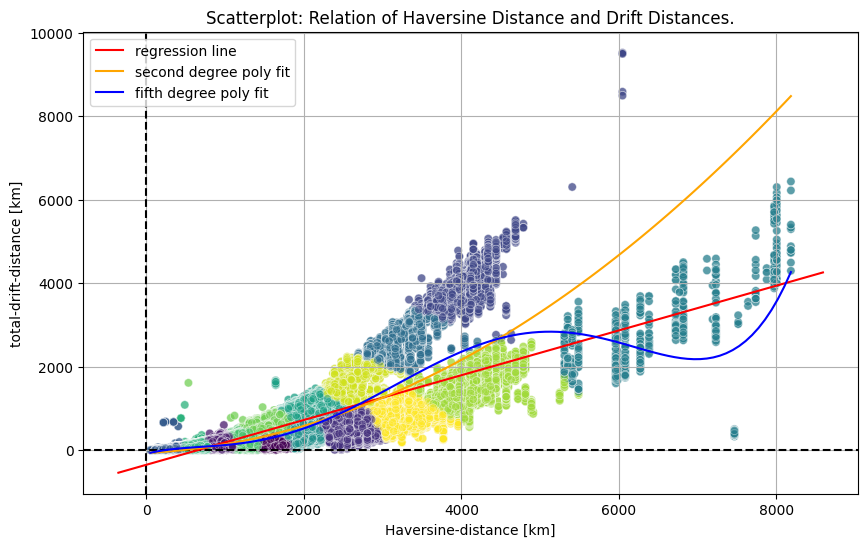

In [89]:
# Let's compare Visually
plt.figure(figsize=(10, 6))
sns.scatterplot(x="haversine_distance", y="total_drift_distance", c=df["kmeans_cluster"], cmap="viridis",data=df, alpha=0.5)

plt.title("Scatterplot: Relation of Haversine Distance and Drift Distances.")
plt.xlabel("Haversine-distance [km]")
plt.ylabel("total-drift-distance [km]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# adding in linear regression  
x_values = np.array(plt.gca().get_xlim())
y_values = sk_b + sk_m * x_values

# plotting linear regression
plt.plot(x_values, y_values, color="red", label="regression line")

# adding polynomials for plot
plt.plot(polya_x_values, polya_y_values, color="orange", label="second degree poly fit")
plt.plot(polyb_x_values, polyb_y_values, color="blue", label="fifth degree poly fit")

plt.grid(True)
plt.legend(loc="upper left")
plt.show()

In [90]:
# Section yet to be written...